In [1]:
# =============================================
# 1. Import necessary libraries
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error



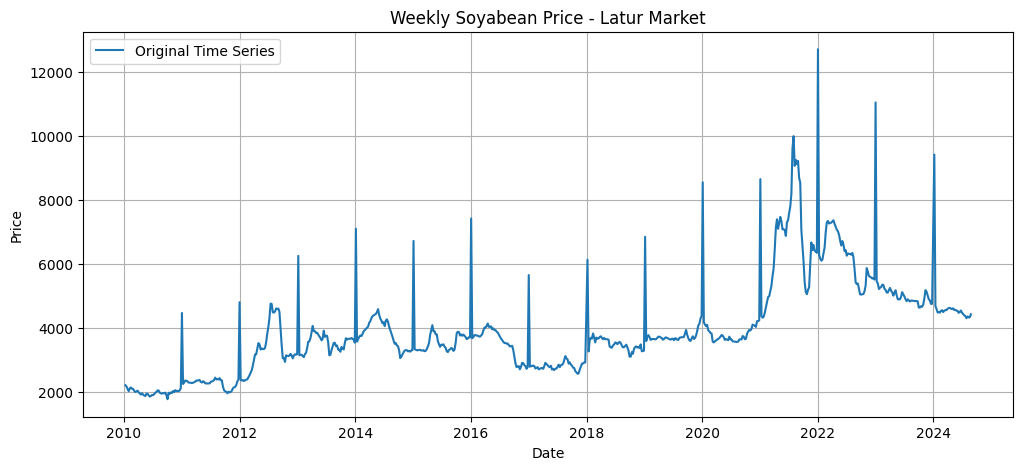

In [3]:

# ===================================================
# 2. Load the dataset (Soyabean Price: Ujjain Market)
# ===================================================
file_path = '/content/Weekly Price Latur Soyabean Market.xlsx'
df = pd.read_excel(file_path, parse_dates=['week_ending_date'])
df = df.rename(columns={'week_ending_date': 'Date', 'Latur_Soya': 'Price'})
df.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Price'], label='Original Time Series')
plt.title('Weekly Soyabean Price - Latur Market')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [4]:

# ======================================================
# 3. SVR requires supervised learning format.
# We'll use previous prices to predict next one (lag=1)
# ======================================================
def create_supervised_data(series, lag=1):
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i+lag])
        y.append(series[i+lag])
    return np.array(X), np.array(y)

price_series = df['Price'].values
X_all, y_all = create_supervised_data(price_series, lag=1)




In [5]:

# ============================================
# 4. Train-Test Split (same 90-10% as ARIMA)
# ============================================
train_size = int(len(X_all) * 0.90)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

print(f"Train samples: {len(X_train)}  |  Test samples: {len(X_test)}")



Train samples: 684  |  Test samples: 77


In [6]:

# ===================================================
# 5. Scale the data (important for SVR performance)
# ===================================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)



In [7]:

# ========================================
# 6. Build and Train SVR Model
# ========================================
# We'll use RBF kernel; adjust C, gamma if needed
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svr_model.fit(X_train_scaled, y_train_scaled)


SVR(C=100, epsilon=0.01, gamma=0.1)

In [8]:

# ========================================
# 7. Forecasting using SVR
# ========================================
train_pred_scaled = svr_model.predict(X_train_scaled)
test_pred_scaled = svr_model.predict(X_test_scaled)

# Inverse scale predictions to original price
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()



In [9]:

# ========================================
# 8. Prepare time index for plotting
# ========================================
train_index = df.index[1:1+len(train_pred)]
test_index = df.index[1+len(train_pred):]


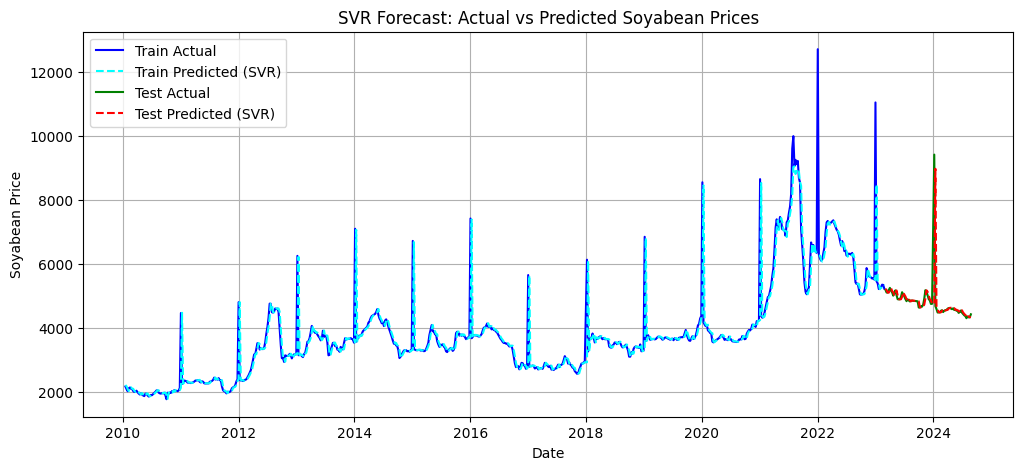

In [10]:

# ========================================
# 9. Plot Actual vs Predicted
# ========================================
plt.figure(figsize=(12, 5))
plt.plot(train_index, y_train, label='Train Actual', color='blue')
plt.plot(train_index, train_pred, label='Train Predicted (SVR)', linestyle='--', color='cyan')
plt.plot(test_index, y_test, label='Test Actual', color='green')
plt.plot(test_index, test_pred, label='Test Predicted (SVR)', linestyle='--', color='red')
plt.title('SVR Forecast: Actual vs Predicted Soyabean Prices')
plt.xlabel('Date')
plt.ylabel('Soyabean Price')
plt.legend()
plt.grid(True)
plt.show()


In [11]:

# ======================================================
# 10. Evaluation Metrics (Train & Test)
# ======================================================
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Train Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)

# Test Metrics
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)

print("\nSVR Training Metrics:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE : {train_mae:.2f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nSVR Testing Metrics:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE : {test_mae:.2f}")
print(f"  MAPE: {test_mape:.2f}%")



SVR Training Metrics:
  RMSE: 707.49
  MAE : 208.10
  MAPE: 4.59%

SVR Testing Metrics:
  RMSE: 725.08
  MAE : 168.43
  MAPE: 2.91%
